In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import mplfinance as mpf
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from tqdm import tqdm
from datetime import datetime

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,531500
...,...,...,...,...,...
2024-06-03,529.020020,529.309998,522.599976,527.799988,46835700
2024-06-04,526.460022,529.150024,524.960022,528.390015,34632700
2024-06-05,530.770020,534.690002,528.729980,534.669983,47610400


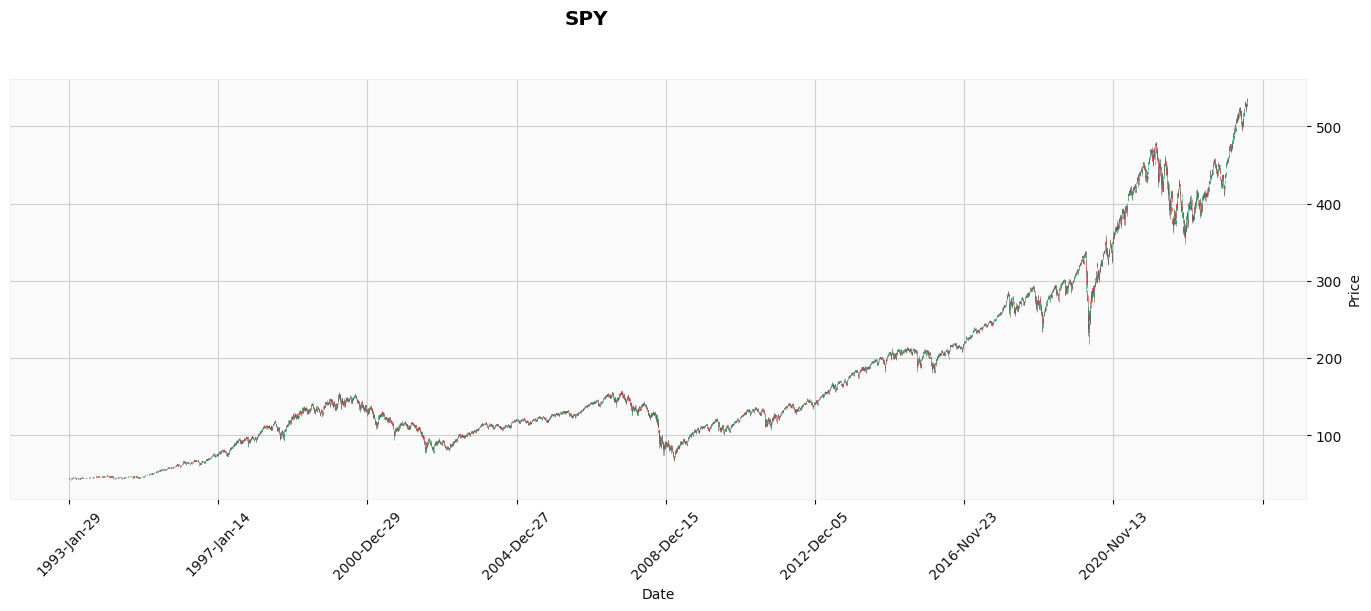

In [10]:
SPY = pd.read_csv("./data/SPY.csv", parse_dates=["Date"], index_col="Date")
SPY.drop(columns=["Adj Close"], inplace=True)
display(SPY)

mpf.plot(
    SPY,
    title="SPY",
    xlabel="Date",
    type="candle",
    figsize=(18, 6),
    style="yahoo",
    warn_too_much_data=len(SPY) + 1,
)

In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(SPY[['Open', 'High', 'Low', 'Close']].values)
scaled_data

array([[1.27126514e-03, 8.86778610e-04, 1.91378284e-03, 1.08139471e-03],
       [1.27126514e-03, 1.45685057e-03, 2.36033216e-03, 1.71750924e-03],
       [1.77977119e-03, 1.71021589e-03, 2.67929597e-03, 1.90834360e-03],
       ...,
       [9.91436839e-01, 9.95540744e-01, 9.91936568e-01, 1.00000000e+00],
       [1.00000000e+00, 9.97020359e-01, 1.00000000e+00, 9.99979624e-01],
       [9.97315074e-01, 1.00000000e+00, 9.99714178e-01, 9.98656581e-01]])

In [4]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        xs.append(data[i : i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)


SEQ_LENGTH = 60  # for example, use last 60 days' data to predict the next day
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = scaler.inverse_transform(y_test)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_test.shape=}")

X_train.shape=torch.Size([6268, 60, 4])
y_train.shape=torch.Size([6268, 4])
X_test.shape=torch.Size([1568, 60, 4])
y_test.shape=(1568, 4)


In [5]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out

In [ ]:
# Hyperparameters
input_size = 4
hidden_size = 128
num_layers = 2
output_size = 4

model = LSTMNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
writer = SummaryWriter()

In [7]:
summary(
    model,
    input_size=(1, 60, 4),
    col_names=["input_size", "output_size", "num_params"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMNetwork                              [1, 60, 4]                [1, 4]                    --
├─LSTM: 1-1                              [1, 60, 4]                [1, 60, 128]              200,704
├─Linear: 1-2                            [1, 128]                  [1, 128]                  16,512
├─Linear: 1-3                            [1, 128]                  [1, 4]                    516
Total params: 217,732
Trainable params: 217,732
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 12.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.87
Estimated Total Size (MB): 0.93

In [11]:
# Clear any logs from previous runs
%rm -rf ./runs/

100%|██████████| 10/10 [00:47<00:00,  4.77s/it, Loss: 0.019349340349435806]


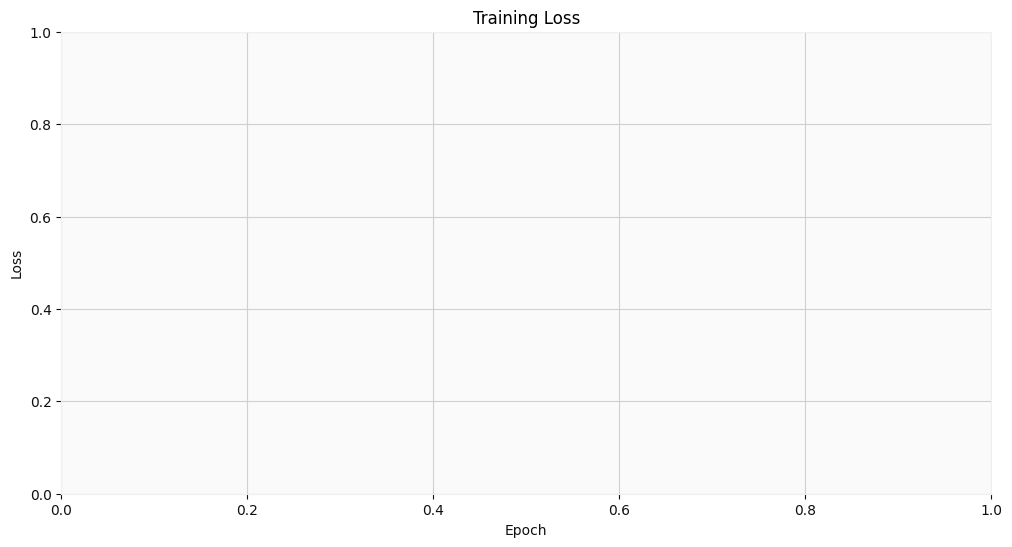

In [ ]:
epochs = 10
for epoch in (pbar := tqdm(range(epochs))):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    pbar.set_postfix_str(f"Loss: {loss.item()}")
    writer.add_scalar("Loss", loss, epoch)
    loss.backward()
    optimizer.step()

writer.flush()
writer.close()

In [34]:
# Create filename for model that includes datetime.now
filename = f"OHLC-model-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
torch.save(model.state_dict(), f"./models/{filename}.model.pt")

torch.save(
    {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    },
    f"./models/{filename}.checkpoint.tar",
)

In [ ]:
model = torch.load('./models/OHLC-model.pt')

In [9]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)

y_test_pred = scaler.inverse_transform(y_test_pred.cpu().numpy())

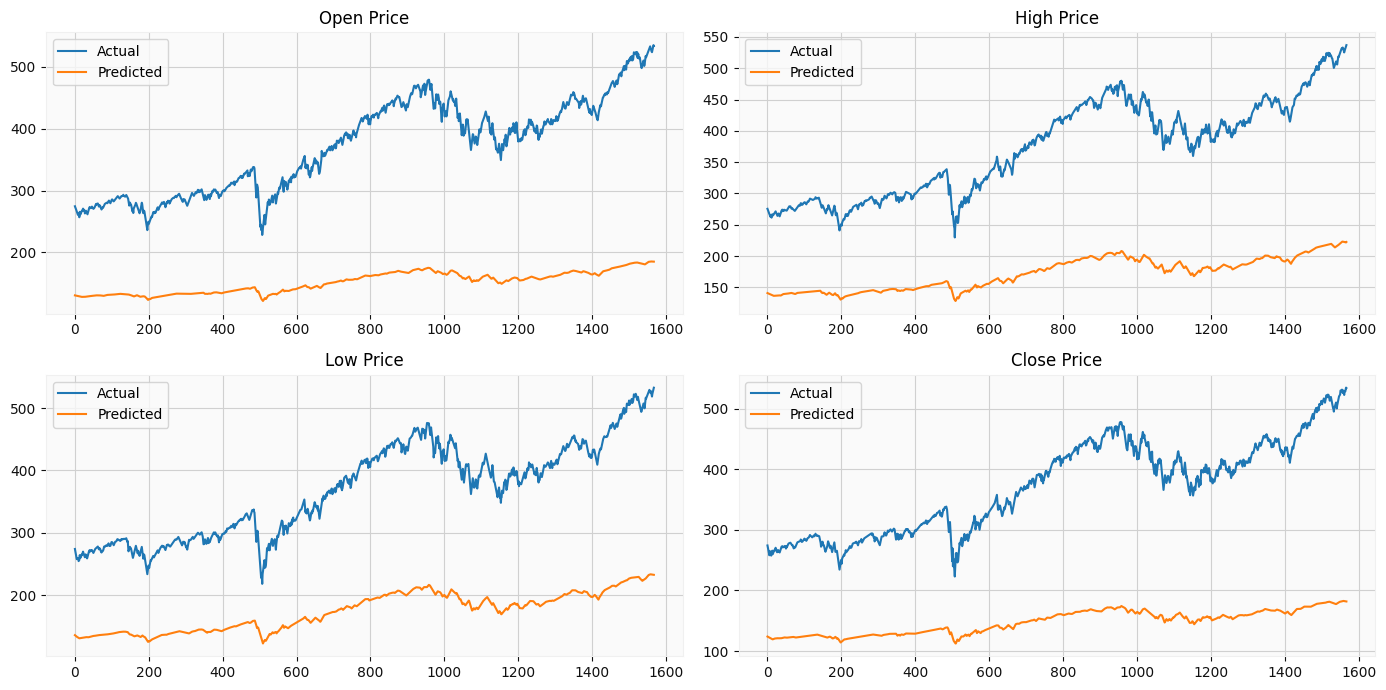

In [10]:
# Plot predictions vs actual values
plt.figure(figsize=(14, 7))

for i, label in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_test_pred[:, i], label='Predicted')
    plt.title(f'{label} Price')
    plt.legend()

plt.tight_layout()
plt.show()